In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages (20.0.2)


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import datetime
import scipy
import pandas as pd
import numpy as np
import itertools
from os import listdir
from os.path import isfile, join
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing 
from sklearn import linear_model
from scipy.optimize import fsolve

In [3]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)

## 辅助函数

In [4]:
def getData(folder_path,symbols):
  file_list = listdir(folder_path)
  tmp_list = []
  for file_name in file_list:
    if file_name.__contains__("csv"):
      tmp_df = pd.read_csv(folder_path+"/"+file_name)
      tmp_df = tmp_df[tmp_df["windcode"]==symbols]
      tmp_df.drop(index = tmp_df.index[[0,120,-1,-2,-3,-4]],inplace=True)
      tmp_list.append(tmp_df)
  data=pd.concat(tmp_list, axis=0, ignore_index=True)

  data["date"] = pd.Series([datetime.datetime.strptime(str(x),"%Y/%m/%d %H:%M").date() for x in data["begintime"]])
  data["time"] = pd.Series([datetime.datetime.strptime(str(x),"%Y/%m/%d %H:%M").time() for x in data["begintime"]])
  data.drop(["begintime","endtime"],axis=1,inplace=True)
  return data

def getEveryDay(begin_date,end_date):
    date_list = []
    while begin_date <= end_date:
        date_str = begin_date
        date_list.append(date_str)
        begin_date += datetime.timedelta(days=1)
    return date_list

# Return df of information, tradeable dates
def getTracebackData(data,begin_date,end_date):
  date_range=getEveryDay(begin_date,end_date)
  tmp_list=[]
  for tmp_date in date_range:
    df = data[data["date"] == tmp_date]
    if (df["volume"].sum()==0.0) |(df["close"].sum()==0.0):
      continue
    tmp_list.append(df)
  if len(tmp_list) == 0:
    return
  data=pd.concat(tmp_list).reset_index(drop=True)
  return data,data["date"].unique()

# given current_date, get N tradeable dates before current_date (exclusive).
def getNTradeDate(data,end_date,N):
  i=0
  begin_date=end_date-datetime.timedelta(days=N)
  while len(getTracebackData(data,begin_date,end_date)[1])<N:
    i+=1
    begin_date = end_date-datetime.timedelta(days=N+i)
  else:
    return begin_date,getTracebackData(data,begin_date,end_date)[1]

def getTimePeriod(name, info, time_length):
  start = datetime.datetime.combine(name,min(info["time"]))
  end = datetime.datetime.combine(name,max(info["time"]))+datetime.timedelta(minutes=1)
  tmp_time = start
  tmp_time_list,tmp_tradeable_list = [],[]
  while tmp_time<end:
    tmp_time_list.append(tmp_time)
    tmp_time+=datetime.timedelta(hours=time_length.hour,minutes=time_length.minute,seconds=time_length.second)
  else:
    tmp_time_list.append(end)
  # Filter out untradeable time
  [tmp_tradeable_list.append(x) for x in tmp_time_list if not (x>datetime.datetime.combine(name,datetime.time(11,29,00)))&(x<datetime.datetime.combine(name,datetime.time(13,00,00)))]
  time_period=[tmp_tradeable_list[i:i+2] for i in range(len(tmp_tradeable_list)-1)]
  return time_period

def getVolumePanel(data,current_date,time_length,N):
  if N == 0:
    data_traceback=getTracebackData(data,current_date,current_date)
    if data_traceback == None:
      print(current_date,"is not a trading date")
      return
    else:
      data_traceback=data_traceback[0]
  else:
    traceback_date = getNTradeDate(data,current_date,N)[0]
    data_traceback=getTracebackData(data,traceback_date,current_date-datetime.timedelta(days=1))[0]
  data_grouped=data_traceback.groupby("date")
  panel_dict={}
  for name, info in data_grouped:
    panel_list,count_list,index_name=[],[],[]
    time_period=getTimePeriod(name, info, time_length)
    for period in time_period:
      start=period[0]
      end=period[1]
      index_name.append(start.time().strftime("%H:%M:%S")+"-"+end.time().strftime("%H:%M:%S"))
      panel_list.append(info[(info["time"]>=start.time()) & (info["time"]<end.time())]["volume"].sum())
      count_list.append(info[(info["time"]>=start.time()) & (info["time"]<end.time())]["volume"].count())
    panel_dict[name]=panel_list
  panel_df=pd.DataFrame(panel_dict,index=index_name)
  count_df=pd.Series(count_list)
  return panel_df,count_df

def getOpenCloseRatio(data,current_date,time_length):
  data_now=getTracebackData(data,current_date,current_date)[0]
  price_ratio_dict={}
  time_period=getTimePeriod(current_date, data_now, time_length)
  index_name = []
  for period in time_period:
    start=period[0]
    end=period[1]
    index_name = start.time().strftime("%H:%M:%S")+"-"+end.time().strftime("%H:%M:%S")
    tmp_df = data_now[(data_now["time"]>=start.time()) & (data_now["time"]<=end.time())]
    open_price = tmp_df["open"].iloc[0] # First open price
    close_price = tmp_df["close"].iloc[-1] # Last close price
    a=0
    if open_price>close_price:
      a=np.sqrt(open_price/close_price)-1
    elif open_price<close_price:
      a=np.sqrt(close_price/open_price)-1
    price_ratio_dict[index_name]=a
  price_ratio_df=pd.Series(price_ratio_dict,name=current_date)
  return price_ratio_df

def exponentialSmoothing(alpha,s):
  s_temp=[s.iloc[:2].mean()]
  for i in range(1,len(s)):
    s_temp.append(alpha*s.iloc[i]+(1-alpha)*s_temp[i-1])
  return pd.Series(s_temp,index=s.index)

def volumeFactorization(panel_df):
  phi=panel_df/panel_df.mean(axis=0)
  theta=phi.expanding(axis=1).mean()
  psi=theta/theta.mean(axis=0)
  eta=panel_df.mean(axis=0)
  mu=panel_df/(eta*psi)
  return eta,mu,psi



def plot_LSTM_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Error')
    plt.legend()
    plt.show()
    
# Plot LSTM Process
class PrintProcess(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(epoch, end='')

## 获取数据

In [172]:
folder_path = "2019-A50/2019-A50"
symbols = "600050.SH"
data=getData(folder_path,symbols)
data.to_csv("600050_data.csv")
data

,windcode,open,high,low,close,volume,amount,date,time
0,600050.SH,5.84,5.85,5.84,5.84,207077.0,1210214.0,2019-11-15,09:31:00
1,600050.SH,5.84,5.85,5.83,5.83,331437.0,1935302.0,2019-11-15,09:32:00
2,600050.SH,5.83,5.84,5.83,5.83,253720.0,1479872.0,2019-11-15,09:33:00
3,600050.SH,5.82,5.83,5.82,5.82,646690.0,3767754.0,2019-11-15,09:34:00
4,600050.SH,5.82,5.83,5.82,5.83,250803.0,1460739.0,2019-11-15,09:35:00
5,600050.SH,5.83,5.83,5.82,5.83,159500.0,928635.0,2019-11-15,09:36:00
6,600050.SH,5.83,5.83,5.81,5.82,1050226.0,6112735.0,2019-11-15,09:37:00
7,600050.SH,5.81,5.83,5.81,5.82,486114.0,2828980.0,2019-11-15,09:38:00
8,600050.SH,5.83,5.83,5.82,5.82,648300.0,3773235.0,2019-11-15,09:39:00
9,600050.SH,5.82,5.83,5.81,5.82,560700.0,3264033.0,2019-11-15,09:40:00


## 成交量预测算法

### 1. 算数平均

In [62]:
def volumePredictNaive(data,current_date,time_length,N):
  panel_df,_ = getVolumePanel(data,current_date,time_length,N)
  ratio_df = panel_df/panel_df.sum(axis=0)
  pred_ratio_df = ratio_df.mean(axis=1)
  pred_vol_df = panel_df.mean(axis=1)
  pred_ratio_df.rename(current_date,inplace=True)
  pred_vol_df.rename(current_date,inplace=True)
  return pred_ratio_df,pred_vol_df

### 2. 指数平均

In [63]:
def volumePredictEWA(data,current_date,time_length,beta,N):
  panel_df,_ = getVolumePanel(data,current_date,time_length,N)
  ratio_df = panel_df/panel_df.sum(axis=0)
  ewm_ratio_dict={}
  ewm_vol_dict={}
  for idx in ratio_df.index.values:
    ewm_ratio_dict[idx] = exponentialSmoothing(beta,ratio_df.loc[idx,:])
    ewm_vol_dict[idx] = exponentialSmoothing(beta,panel_df.loc[idx,:])
  ewm_ratio_df = pd.DataFrame(ewm_ratio_dict).T
  ewm_vol_df = pd.DataFrame(ewm_vol_dict).T

  pred_ratio_df = ewm_ratio_df.iloc[:,-1]*(1-beta)+beta*ratio_df.iloc[:,-1]
  pred_vol_df = ewm_vol_df.iloc[:,-1]*(1-beta)+beta*panel_df.iloc[:,-1]
  pred_ratio_df.rename(current_date,inplace=True)
  pred_vol_df.rename(current_date,inplace=True)
  return pred_ratio_df,pred_vol_df

### 3. 成交量面板因子分解

In [64]:
def volumePredictPanel(data,current_date,time_length,alpha,beta,N):
  panel_df,_ = getVolumePanel(data,current_date,time_length,N)
  m,k = panel_df.shape
  eta,mu,psi = volumeFactorization(panel_df)
  eta_bar = exponentialSmoothing(alpha,eta)
  tmp_dict = {}
  for idx in mu.index:
    tmp_dict[idx]=(exponentialSmoothing(beta,mu.loc[idx,:]))
  mu_bar = pd.DataFrame(tmp_dict).T

  psi_pred = psi.iloc[:,-1]
  eta_pred = eta_bar[-1]*(1-alpha)+eta[-1]*alpha
  mu_pred=(1-beta)*mu_bar.iloc[:,-1]+beta*mu.iloc[:,-1]

  vol_pred = psi_pred*eta_pred*mu_pred
  ratio_pred = vol_pred/(m*eta_pred)
  vol_pred.rename(current_date,inplace=True)
  ratio_pred.rename(current_date,inplace=True)
  return ratio_pred,vol_pred

### 4. 成交量面板因子分解+动态调整

In [66]:
def volumePredictDynamic(data,current_date,time_length,alpha,beta,N):
  modify_df = getOpenCloseRatio(data,current_date,time_length)
  ratio_pred,vol_pred = volumePredictPanel(data,current_date,time_length,alpha,beta,N)
  dynamic_ratio_pred=(modify_df+1)*ratio_pred
  dynamic_vol_pred=(modify_df+1)*vol_pred
  return dynamic_ratio_pred,dynamic_vol_pred

### 5. 线性回归模型

In [163]:
def volumePredictLinear(data,current_date,time_length,N):
  train,_ = getVolumePanel(data,current_date,time_length,N)
  test_y,_ = getVolumePanel(data,current_date,time_length,0)
    
  # Scale Data
  scaler1 = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  scaler2 = preprocessing.MinMaxScaler(feature_range=(-1, 1))

  scaled_train = scaler1.fit_transform(train)
  test_y = scaler2.fit_transform(test_y)
  
  # Train Test Split
  train_x = scaled_train[:,:-1]
  train_y = scaled_train[:,-1]
  test_x = scaled_train[:,1:]
  
  lasso = linear_model.Lasso(alpha=0)
  ridge = linear_model.RidgeCV()

  lasso.fit(train_x,train_y)
  ridge.fit(train_x,train_y)
  
  pred_lasso = lasso.predict(test_x).reshape(-1,1)
  pred_ridge = ridge.predict(test_x).reshape(-1,1)
  
  pred_vol_lasso=scaler2.inverse_transform(pred_lasso).ravel()
  pred_vol_ridge=scaler2.inverse_transform(pred_ridge).ravel()
  
  return pred_vol_lasso,pred_vol_ridge

### 6. 基于LSTM的成交量预测

In [169]:
# Multiple LSTM Layers
def build_model(lstm_layers,window_size):
    model = keras.Sequential()
    #First LSTM Layer
    model.add(keras.layers.LSTM(units=32, activation='sigmoid',input_shape=window_size,return_sequences=True))
    
    #Middle LSTM Layers, add drop to avoid over fitting
    i = 0
    while i < lstm_layers - 2:
        model.add(keras.layers.LSTM(units=32 * (i+1),activation='sigmoid',return_sequences=True,dropout=0.01))
        model.add(keras.layers.Dropout(0.2))
        i+=1
    
    #Last LSTM Layers, set return_sequences=False
    model.add(keras.layers.LSTM(units=32 * (i+1),activation='sigmoid',return_sequences=False,dropout=0.01))
    model.add(keras.layers.Dropout(0.2))
    
    #Dense for regression output
    model.add(keras.layers.Dense(units=1))
        
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [170]:
def volumePredictLSTM(data,current_date,time_length,days,num_layers,epochs,time_steps=5,date_steps=10,multiplier=5):
  # WindowSize Setting
  ###

  # Get Train Data
  data_train=getVolumePanel(data,current_date,time_length,days)[0]

  # Check dimension
  ## Panel data will have days-1 columns, since it will get stops at one previous tradeable date
  print("Check if we have the same tradeable days:",days==data_train.shape[1]+1)
  window_size = (time_steps,data_train.shape[1]-multiplier)
  print("Sliding widow size",window_size)
  
  # Get Test Data
  data_test_y=getVolumePanel(data,current_date,time_length,0)[0]
  data_test_y=data_test_y[window_size[0]-1:]

  # Scale Data
  scaler1 = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  scaled_train = scaler1.fit_transform(data_train)
  scaled_train = pd.DataFrame(scaled_train)

  scaler2 = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  test_y = scaler2.fit_transform(data_test_y).ravel()

  # Build Train & Test Set
  list_train_x, list_train_y, list_test_x=[], [], []
  for i in range(scaled_train.shape[0]-window_size[0]+1):
    list_test_x.append(scaled_train.iloc[i:i+window_size[0],-window_size[1]:].values)
    for j in range(multiplier):
      tmp_x=scaled_train.iloc[i:i+window_size[0],j:j+window_size[1]].values
      tmp_y=scaled_train.iloc[i+window_size[0]-1,j+window_size[1]]
      list_train_x.append(tmp_x)
      list_train_y.append(tmp_y)

  train_x=np.array(list_train_x)
  train_y=np.array(list_train_y)
  test_x=np.array(list_test_x)

  # train_x and test_x should have the same dimensions as widow_size
  print(train_x.shape)
  print(train_y.shape)
  print(test_x.shape)
  print(test_y.shape)

  LSTM_model=build_model(num_layers,window_size)
  history = LSTM_model.fit(train_x, train_y, epochs=epochs,callbacks=[PrintProcess()], 
                           batch_size=1,validation_split=0.2,verbose=0)

  plot_LSTM_history(history)
  pred_y = LSTM_model.predict(test_x)
  pred_vol = scaler2.inverse_transform(pred_y).ravel()
  
  return pred_vol

## 超参数设置

In [213]:
N=30
current_date=datetime.date(2019,11,29)
time_length=datetime.time(00,1,00)
beta=0.3
alpha=0.3
test_length=1
time_steps=5

Check if we have the same tradeable days: True
Sliding widow size (5, 24)
(1160, 5, 24)
(1160,)
(232, 5, 24)
(232,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 5, 32)             7296      
_________________________________________________________________
lstm_28 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_21 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 5, 64)             24832     
_________________________________________________________________
dropout_22 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 96)             61824     
__________________________

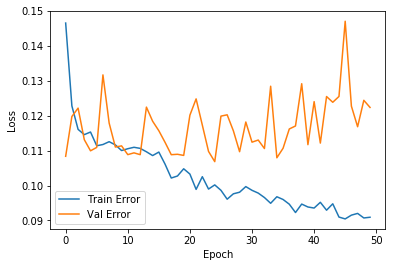

In [216]:
pred_LSTM = volumePredictLSTM(data,current_date,time_length,N,num_layers=5,epochs=50,time_steps=time_steps,date_steps=10,multiplier=5)

In [217]:
%time pred_naive=volumePredictNaive(data,current_date,time_length,N)[1]
%time pred_ewm=volumePredictEWA(data,current_date,time_length,beta,N)[1]
%time pred_factor=volumePredictPanel(data,current_date,time_length,alpha,beta,N)[1]
%time pred_dynamic=volumePredictDynamic(data,current_date,time_length,alpha,beta,N)[1]
%time pred_lasso,pred_ridge=volumePredictLinear(data,current_date,time_length,N)

CPU times: user 19.3 s, sys: 42 ms, total: 19.3 s
Wall time: 19.3 s
CPU times: user 19.4 s, sys: 30.9 ms, total: 19.4 s
Wall time: 19.4 s
CPU times: user 19.1 s, sys: 31.3 ms, total: 19.2 s
Wall time: 19.2 s
CPU times: user 19.6 s, sys: 42 ms, total: 19.6 s
Wall time: 19.6 s
CPU times: user 19.5 s, sys: 32 ms, total: 19.5 s
Wall time: 19.5 s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


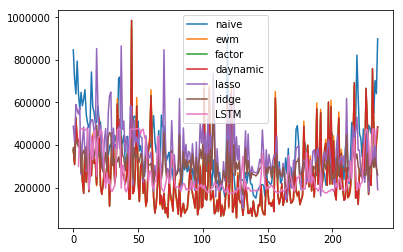

In [218]:
plt.plot(range(236),pred_naive,label="naive")
plt.plot(range(236),pred_ewm,label="ewm")
plt.plot(range(236),pred_factor,label="factor")
plt.plot(range(236),pred_dynamic,label="daynamic")
plt.plot(range(236),pred_lasso,label="lasso")
plt.plot(range(236),pred_ridge,label="ridge")
plt.plot(range(time_steps-1,236),pred_LSTM,label="LSTM")
plt.legend()

In [219]:
def statsMeasure(pred_vol,real_vol,real_price):
  
  def MAPE(pred_vol,real_vol,real_price):  
    real_vwap = real_vol*real_price/real_vol.sum()
    pred_vwap = pred_vol*real_price/pred_vol.sum()
    return np.mean(abs(real_vwap-pred_vwap)/real_vwap)
  
  stats_dict={}
  # scale by 10^(-5)
  stats_dict['MAE'] = metrics.mean_absolute_error(real_vol,pred_vol)/(10.**5)
  # scale by 10^(-10)
  stats_dict['MSE'] = metrics.mean_squared_error(real_vol,pred_vol)/(10.**10)
  stats_dict['R2'] = metrics.r2_score(real_vol,pred_vol)
  stats_dict["MAPE"] = MAPE(pred_vol,real_vol,real_price)
  
  return pd.Series(stats_dict)

real_data = getTracebackData(data,current_date,current_date)[0]
real_price=real_data.loc[:,"close"].values
real_vol=real_data.loc[:,"volume"].values

stats_dict={}
pred_list = ["pred_naive","pred_ewm","pred_factor","pred_dynamic","pred_lasso","pred_ridge"]
for pred in pred_list:
  stats_dict[pred] = statsMeasure(eval(pred),real_vol,real_price)
stats_dict["pred_LSTM"] = statsMeasure(pred_LSTM,real_vol[time_steps-1:],real_price[time_steps-1:])
pd.DataFrame(stats_dict)

,pred_naive,pred_ewm,pred_factor,pred_dynamic,pred_lasso,pred_ridge,pred_LSTM
MAE,2.394747,1.590673,1.600175,1.600706,2.486273,2.037679,1.804702
MSE,8.026280,5.317748,5.300898,5.303743,8.532382,5.756115,5.413444
R2,-1.035034,-0.348296,-0.344023,-0.344745,-1.163354,-0.459442,-0.371184
MAPE,1.166251,1.239304,1.241906,1.241798,1.329467,1.319029,1.263605


## IS算法

In [ ]:
#X=10000
# p is expected portion of volumes you executed one time out of your total volumes
p=10./100.
L=10**(-6)
E = 15000

class IS:
  def __init__(self,data,current_date,p,L,E,days):
    traceback_date,_ = getNTradeDate(data,current_date,days)
    data_traceback=getTracebackData(data,traceback_date,current_date-datetime.timedelta(days=1))[0]
    self.data_current = getTracebackData(data,current_date,current_date)[0]
    data_daily=data_traceback[data_traceback.loc[:,"time"]==datetime.time(14,56,00)]
    S0=data_daily["close"].iloc[-1]
    
    # predict today's market total volume
    vol_pred=np.mean(data_daily["amount"].iloc[-7:])
    
    self.T=236
    self.N=236
    self.t=1

    self.E=E

    self.fixCost=S0*0.003
    self.X=vol_pred*p
    # daily close price's std * initial price S0
    self.sigma=np.std(data_daily.loc[:,"close"])/data_daily.shape[0]*S0
    self.tau=0.01*S0/(0.1*self.X)
    self.gamma=0.001*S0/(0.1*self.X)
    self.kappa=np.sqrt(L*self.sigma*2/self.tau)

  def calcMinExp(self):
    print("交易量: ", self.X)
    return 0.5*self.gamma*self.X**2+self.fixCost*self.X+(self.tau-0.5*self.gamma*self.t)*self.X**(2)/self.T

  def calcMaxExp(self):
    print("交易量: ", self.X)
    return self.fixCost*self.X+self.tau*self.X**(2)/self.t

  def calcLambda(self):
    def func(x):
      kappa = np.sqrt(x*self.sigma**2/self.tau)
      tmp_E=0.5*self.gamma*self.X**2+self.fixCost*self.X+self.tau*self.X**2*np.tanh(kappa*self.t/2.)*(self.t*np.sinh(2*kappa*self.T)+2*self.T*np.sinh(kappa*self.t))/(2.*self.t**2*(np.sinh(kappa*self.T))**2)
      return tmp_E-self.E
    return scipy.optimize.fsolve(func, [10.**(-8)])
    
  def calcOrder(self,*arg):
    if len(arg)==0:
      L = self.calcLambda()[0]
    else:
      L = arg[0]
    print("Lambda: ",L)
    kappa = np.sqrt(L*self.sigma**2/self.tau)
    order_list=[]
    for j in range(self.N):
      tmp_t=(j-0.5)*self.t
      tmp_order = 2*np.sinh(kappa*self.t/2.)/np.sinh(kappa*self.T)*np.cosh(kappa*(self.T-tmp_t))*self.X
      if tmp_order<1.:
        tmp_order=0.
      order_list.append(np.floor(tmp_order))
    return order_list
  
  def calcMAPE(self):
    IS_order = self.calcOrder()
    real_vwap_list = self.data_current.loc[:,"volume"]*self.data_current.loc[:,"close"]/self.data_current.loc[:,"volume"].sum()
    IS_vwap_list = IS_order*self.data_current.loc[:,"close"]/sum(IS_order)
    MAPE=np.mean(abs(IS_vwap_list-real_vwap_list)/real_vwap_list)
    print("实际下单交易量: ",sum(IS_order))
    return MAPE

model=IS(data,current_date,p,L,E,N)
print("期望冲击成本最大值: ", model.calcMaxExp())
print("期望冲击成本最小值: ", model.calcMinExp())
print("MAPE: ",model.calcMAPE())
for L in [10**x for x in [-6,-7,-8]]:
  print(L)
  order_list=model.calcOrder(L)
  plt.bar(range(len(order_list)),order_list,alpha=0.3,label=L)
plt.legend()
plt.show()

In [ ]:

def predAccuracyDist(data,current_date,time_length,test_length,beta,N,plot=True,stats=True):
  
  _,tradeable_dates=getNTradeDate(data,current_date,test_length-1)
  real_list,factor_list,dynamic_list,ewm_list, naive_list,xaxis_list = [],[],[],[],[],[]

  for date in tradeable_dates:
    print(date)
    real,_ = getVolumePanel(data,date+datetime.timedelta(days=1),time_length,1)
    real_ratio=real/real.sum()

    naive_pred,_ = volumePredictNaive(data,date,time_length,N)
    ewm_pred,_ = volumePredictEWA(data,date,time_length,beta,N)
    factor_pred,_ = volumePredictPanel(data,date,time_length,beta,beta,N)
    dynamic_pred = volumePredictDynamic(data,date,time_length,beta,beta,N)
    
    #print(real_ratio)
    
    xaxis_list.extend([date.strftime("%y-%m-%d")+" "+x for x in real.index.values])
    real_list.extend(real_ratio.values.ravel().tolist())
    naive_list.extend(naive_pred.values.ravel().tolist())
    ewm_list.extend(ewm_pred.values.ravel().tolist())
    factor_list.extend(factor_pred.values.ravel().tolist())
    dynamic_list.extend(dynamic_pred.values.ravel().tolist())

  if plot:
    fig = plt.gcf()
    fig.set_size_inches(40, 12)
    plt.plot(xaxis_list,real_list,c="blue",label="Real Volume Ratio")
    plt.plot(naive_list,c="orange",label="Volue Ratio: Simple Average",alpha=0.7)
    plt.plot(ewm_list,c="green",linestyle="--",label="Volue Ratio: Exponential Average",alpha=0.7)
    plt.plot(factor_list,c="red",label="Volue Ratio: Factor",alpha=0.7)
    plt.plot(dynamic_list,c="black",linestyle=":",label="Volume Ratio: Dynamic",alpha=0.7)
    plt.legend(loc='best',fontsize=15)
    plt.xticks(fontsize=10,rotation=90)
    plt.show()

  if stats:
    stats_dict={}
    pred_list = ["factor_list","dynamic_list","ewm_list","naive_list"]
    for pred in pred_list:
      stats_dict[pred[:-5]] = statsMeasure(real_list,eval(pred))
  return pd.DataFrame(stats_dict)

predAccuracyDist(data,current_date,time_length,test_length,beta,N,plot=True,stats=True)

In [ ]:
symbol_list = ["601989.SH","600703.SH",]#,"600887.SH","601988.SH","601328.SH","600028.SH","601186.SH"]
for symbol in symbol_list:
  data=getData(folder_path,symbol)
  real_df,_ = getTracebackData(data,current_date,current_date)
  real_vwap=np.cumsum(real_df.loc[:,"volume"]/real_df.loc[:,"volume"].sum())
  plt.plot(real_vwap,label=symbol)
plt.legend()